In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('dark' + 'grid')
sns.set_palette('muted')
survival_palette={'Survived':'mediumaquamarine', 'Not survived':'lightcoral'}
# Gender colors will be the default muted blue and orange for males and females, respectively
# Other colors will be assigned as necessary
# Source for colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html

## 1.0 Importing Data

Import training data, and perform a quick overview of available data types.

In [3]:
df = pd.read_csv('Data/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# General statistical information about the dataset
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Analyze missing values, which will be remediated at a later time. 

Cabin has many missing values (77%), will consider dropping if no relationships found with other variables. 

Possibly fill missing values of age with median due to high standard deviation?

Embarked only has two missing values, can fill with most common value.

In [4]:
total = df.isnull().sum().sort_values(ascending=False)
percent = total/len(df) * 100
percent = round(percent, 2)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', '%'])
missing_data.head()

,Total,%
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00


### 1.1 Added columns

Below are columns we've added to the dataset throughout our analysis. We've put them into one spot for convenience.

In [3]:
#Uncomment as necessary
df['Sex_num'] = df['Sex'].map({'female': 0, 'male': 1})
df['Relatives'] = df['SibSp'] + df['Parch']
def extract_name(name):
    titles = ['Mr.', 'Don', 'Dr.', 'Rev', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer', 'Mrs.', 'Ms.', 'Mme', 'Lady', 'Mlle', 'Countess', 'Dona', 'Miss', 'Master']
    for title in titles:
        if title in name:
            return title
df['Title'] = df.apply(lambda row: extract_name(row['Name']), axis=1)
df['Target_name'] = df['Survived'].map({0: 'Not survived', 1: 'Survived'})

Defining functions which will be used repetitively throughout data exploration.

In [16]:
def plot_pct_labels(ax):
    ''' 
    Plots the percent values on each series in a plot.
    '''
    for i, p in enumerate(ax.patches):
        ax.text(p.get_x()+p.get_width()/2, p.get_height() + 3,
                '{:1.2f}%'.format(p.get_height()/len(df)*100), ha="center") 

## 2.0 Data Exploration

 - Numerical data: 
    - Continuous: Age, Fare
    - Discrete: Sibsp, Parch
 - Categorical data:
    - Ordinal (order matters): Pclass
    - Nominal: Sex, Survived, Cabin, Embarked

Used a heatmap to assess any preliminary relationships between the data. Note, Pearson Correlation is typically for used for continuous data and categorical data with only two variables (i.e. survived and gender). For ordinal data, Spearman Correlation is recommended, however in this case they give very similar results since our ordinal data already has a numerical transformation. Took out Sibsp and Parch because they are not continuous or ordinal.

**Observations**

We observe a strong relationship between Gender and Survivived (females survived more), and medium inverse relationship between Pclass and Survived (lower Pclass survived more).

Also, medium relationship between Fare and Pclass, as expected, and with age and Pclass.

Resource for Pearson correlation: https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php

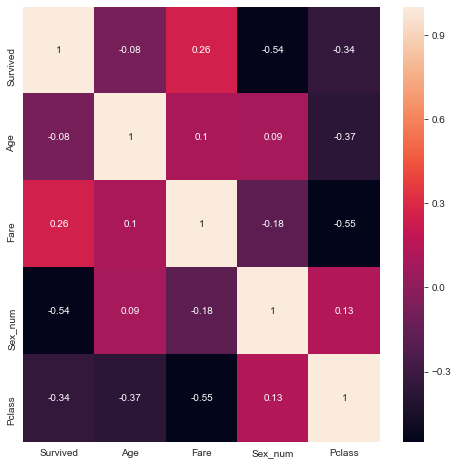

In [7]:
df['Sex_num'] = df['Sex'].map({'female': 0, 'male': 1})
cor_matrix = df[['Survived', 'Age', 'Fare', 'Sex_num', 'Pclass']].corr(method='pearson').round(2)
plt.figure(figsize=(8,8))
ax = sns.heatmap(cor_matrix,annot=True);
ax.figure.savefig('Plots/heatmap.png')

## 2.1 Total Survival Rate

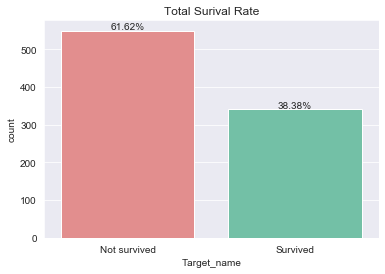

In [17]:
df['Target_name'] = df['Survived'].map({0: 'Not survived', 1: 'Survived'})
ax = sns.countplot(x='Target_name', data=df, palette=survival_palette)
ratio = df[df.Survived==1].shape[0]/df.shape[0]
plot_pct_labels(ax)
ax.set_title("Total Surival Rate");
ax.figure.savefig('Plots/total_survival_rate.png')

## 2.2 Age

Mostly middle aged adults, very few senior citizens.

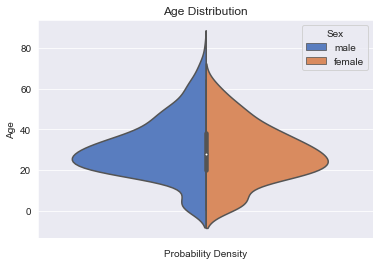

In [18]:
# Common column required for split violin plot to work (not sure if this is a bug?), dropped after use
df['All'] = ""
ax = sns.violinplot(y='Age', x='All', hue='Sex', data=df, split=True);
ax.set_title('Age Distribution');
ax.set_xlabel('Probability Density')
df.drop('All', axis=1, inplace=True)
ax.figure.savefig('Plots/age_distribution.png')

Median and mean age for those who survivors and non-survivors are both very similar. **Age by *itself* does not seem to be a critical feature.**

Median age of survivors and non-survivors: 28.0, 28.0
Average age of survivors and non-survivors: 28.34, 30.63


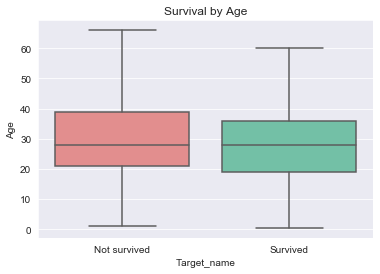

In [19]:
ax = sns.boxplot(y='Age', x='Target_name', data=df, showfliers = False, palette=survival_palette);
ax.set_title('Survival by Age')
ax.figure.savefig('Plots/survival_by_age.png')
print(f"Median age of survivors and non-survivors: {df[df.Survived==1].Age.median()}, {df[df.Survived==0].Age.median()}")
print(f"Average age of survivors and non-survivors: {df[df.Survived==1].Age.mean():.2f}, {df[df.Survived==0].Age.mean():.2f}")

## 2.3 Gender

Woman showed a much higher survival rate (74.20%) than men (18.89%).

In [21]:
print("74% of females survived versus only 19% of males.")
df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

74% of females survived versus only 19% of males.


,Sex,Survived
0,female,0.742038
1,male,0.188908


In [22]:
women = df[df.Sex=='female']
men = df[df.Sex=='male']
print(f"The number of females was {women.shape[0]} and number of males was {men.shape[0]}.")

The number of females was 314 and number of males was 577.


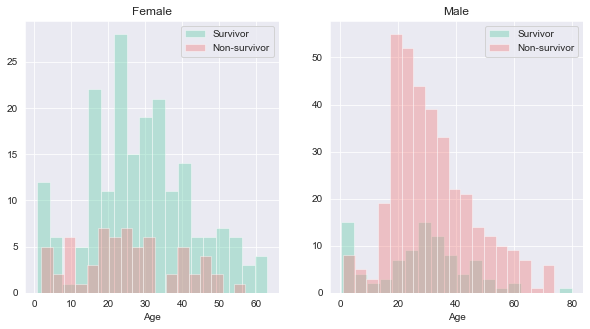

In [23]:
# Middle aged men were more likely to not survive
fig, axes = plt.subplots(1,2,figsize=(10,5))

ax = sns.distplot(women[women.Survived==1].Age.dropna(), kde=False, ax=axes[0], label='Survivor', bins=18, color='mediumaquamarine')
ax = sns.distplot(women[women.Survived==0].Age.dropna(), kde=False, ax=axes[0], label='Non-survivor', bins=18,color='lightcoral')
ax.set_title('Female')
ax.legend()

ax = sns.distplot(men[men.Survived==1].Age.dropna(), kde=False, ax=axes[1], label='Survivor', bins=18, color='mediumaquamarine')
ax = sns.distplot(men[men.Survived==0].Age.dropna(), kde=False, ax=axes[1], label='Non-survivor', bins=18, color='lightcoral')
ax.set_title('Male')
ax.legend();
fig.savefig('Plots/age_gender_hist.png')


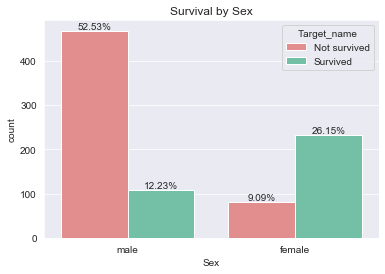

In [26]:
ax = sns.countplot(x='Sex', hue="Target_name", data=df, palette=survival_palette);
total = [len(df[df.Sex==i]) for i in df.Sex.sort_values(ascending=False).unique()] * 2
plot_pct_labels(ax)
ax.set_title("Survival by Sex");
ax.figure.savefig('Plots/survival_by_sex.png')

## 2.4 Pclass

Those in the Pclass 3 (the lowest tier class) showed the lowest survival rate (24.2%).

In [14]:
df[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


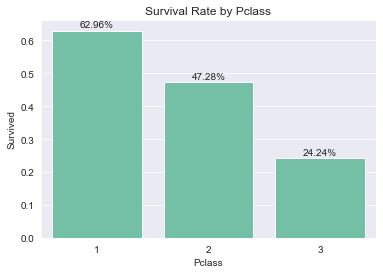

In [28]:
# Plotting above numbers
ax = sns.barplot(x='Pclass', y='Survived', data=df, color='mediumaquamarine', ci=None);
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.01,
            '{:1.2f}%'.format(p.get_height()*100), ha="center") 
ax.set_title('Survival Rate by Pclass');
ax.figure.savefig('Plots/survival_by_pclass.png')

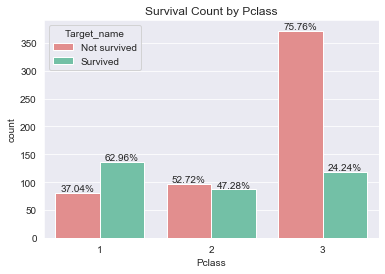

In [16]:
ax = sns.countplot(x='Pclass', hue="Target_name", data=df, palette=survival_palette);
total = [len(df[df.Pclass==i]) for i in df.Pclass.sort_values(ascending=True).unique()] * 2
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height() + 3,
            '{:1.2f}%'.format(p.get_height()/total[i]*100), ha="center") 
ax.set_title("Survival Count by Pclass");

As expected, Pclass 3 had mostly males, and thus aligns with the survivor rate we saw in gender.

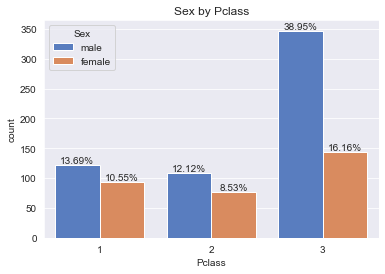

In [30]:
ax = sns.countplot(x='Pclass', hue="Sex", data=df);
total = [len(df[df.Pclass==i]) for i in df.Pclass.sort_values(ascending=True).unique()] * 2
plot_pct_labels(ax)
ax.set_title("Sex by Pclass");
ax.figure.savefig('sex_by_pclass.png')

## 2.5 Fare

We know that Fare and Pclass have some relationship, and it's confirmed by the plot below. As we would expect, those in the highest tier class (Pclass=1), were paying substantially higher fares.

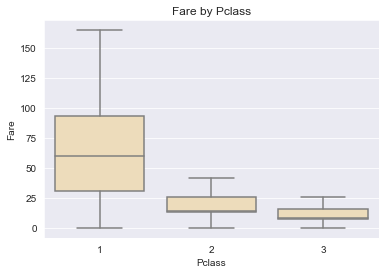

In [31]:
ax = sns.boxplot(y='Fare', x='Pclass', data=df, showfliers=False, color='wheat');
ax.set_title('Fare by Pclass');
ax.figure.savefig('fare_by_pclass.png')

Again, those that survived where paying on average higher fares.

Average fare of survivors was 48.40, and non-survivors was 22.12.


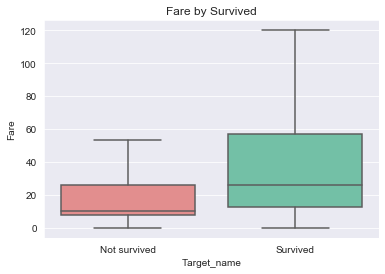

In [32]:
ax = sns.boxplot(y='Fare', x='Target_name', data=df, showfliers=False, palette=survival_palette);
ax.set_title('Fare by Survived');
print(f"Average fare of survivors was {df[df.Survived==1].Fare.mean():.2f}, and non-survivors was {df[df.Survived==0].Fare.mean():.2f}.")
ax.figure.savefig('Plots/fare_by_pclass.png')

Passengers between the ages of 10 to 30, and 70 to 80 paid the least for their fares.

Note that any fares above $200 are not shown.

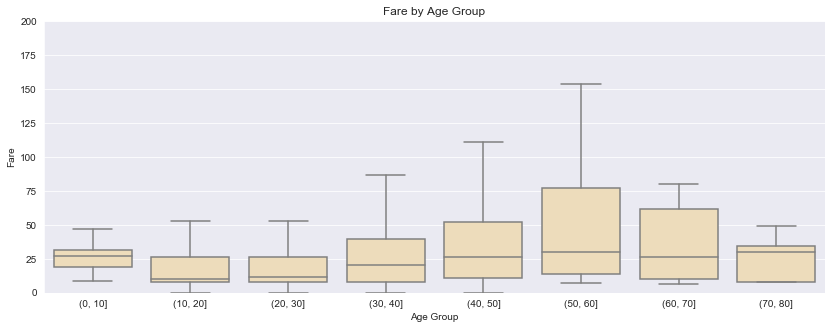

In [122]:
plt.figure(figsize=(14,5))
df['age_group'] = pd.cut(df['Age'], bins=range(0, 81, 10))
ax = sns.boxplot(x="age_group", y="Fare", data=df, color='wheat', showfliers=False)
ax.set_title('Fare by Age Group');
ax.set_xlabel('Age Group');
ax.set(ylim=(0,200));
ax.figure.savefig('Plots/fare_by_age')
df.drop(['age_group'], axis=1, inplace=True)

Upon further analysis, it was learned that people with the same ticket number have the same fare. To get a per person cost we will need to divide these the fare price by the number of occurences of that ticket number. This will be accomplished later during feature engineering.

In [76]:
# Example with passengers with the same ticket number
tickets = df.groupby(['Ticket'])['Ticket'].count()
print(tickets.head(), '\n')
df[df['Ticket']=='110152']

Ticket
110152    3
110413    3
110465    2
110564    1
110813    1
Name: Ticket, dtype: int64 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Target_name,age_group,Relatives,Title
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5,B77,S,0,Survived,"(20, 30]",0,Miss
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5,B79,S,0,Survived,"(10, 20]",0,Miss
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,0,Survived,"(30, 40]",0,Countess


## 2.6 Embarked

Three possible embarking locations, with a majority embarking from port 'S'. 

Location 'S' also had the highest number of Pclass 3 passengers, and therefore we'd expect the lowest likelihood of survival from that port. 

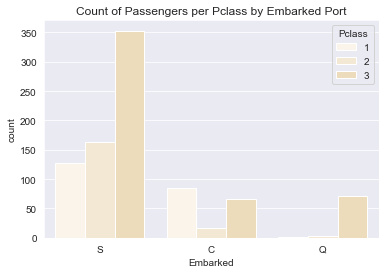

In [37]:
ax = sns.countplot(x='Embarked', hue='Pclass', data=df, color='wheat')
ax.set_title('Count of Passengers per Pclass by Embarked Port');
ax.figure.savefig('Plots/embarked_pclass.png')

As expected, passengers who embarked at port 'S' had the lowest likelihood of survival. Port 'C' had the highest survival rate, due to most passengers being in Pclass 1. **Seems to be a correlation mostly between Pclass and Survival rather than Embark with Survival directly**.

**Note**: A line plot may not be the best way to show this because Embarked is not continuous data, other options?

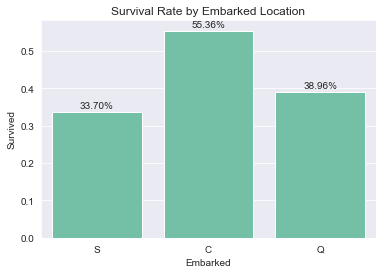

In [40]:
ax = sns.barplot(x='Embarked', y='Survived', data=df, color='mediumaquamarine', ci=None);
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.01,
            '{:1.2f}%'.format(p.get_height()*100), ha="center") 
ax.set_title('Survival Rate by Embarked Location');
ax.figure.savefig('Plots/survival_by_embarked')

## 2.7 Sibsp and Parch

Number of siblings and parents/children on board can logically be combined together into a single field representing the number of relatives.

Credit to here for the idea: https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

In [42]:
df['Relatives'] = df['SibSp'] + df['Parch']
df[['SibSp', 'Parch', 'Relatives']].head()

,SibSp,Parch,Relatives
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0


We notice a substantial dip in likelihood of survival after a number of relatives of 3 (with the exception of 6).

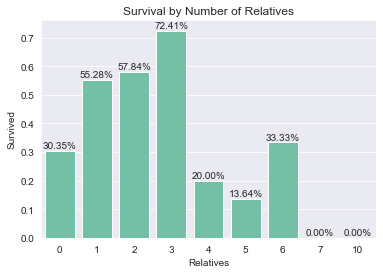

In [43]:
ax = sns.barplot(x='Relatives', y='Survived', data=df, color='mediumaquamarine', ci=None);
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.01,
            '{:1.2f}%'.format(p.get_height()*100), ha="center") 
ax.set_title("Survival by Number of Relatives");
ax.figure.savefig('Plots/survival_by_relatives.png')

## 2.8 Passenger Title

Each passenger name given in the dataset has an associated title. Note some of the titles are in French or abbreviated and can be combined during data cleaning (i.e. Mlle, Ms, Mme).

The title appears to correlate to the age of the passenger in some cases (e.g. Master, Major, Reverend, etc).

In [44]:
# Extract the title for each person from the name attribute.
df["Title"] = ""

def extract_name(name):
    titles = ['Mr.', 'Don', 'Dr.', 'Rev', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer', 'Mrs.', 'Ms.', 'Mme', 'Lady', 'Mlle', 'Countess', 'Dona', 'Miss', 'Master']
    for title in titles:
        if title in name:
            return title

df['Title'] = df.apply(lambda row: extract_name(row['Name']), axis=1)

As seen in the plot below, by far the most occuring titles are Mr., Mrs., Miss and Master. It may be of value to combine the lesser occuring titles.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Relatives,Title,Target_name
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,1,1,Sir,Survived


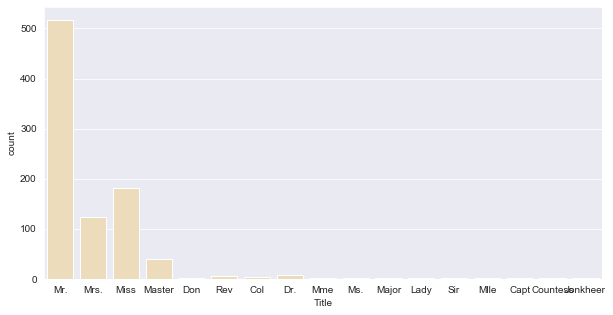

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x='Title', data=df, color='wheat')

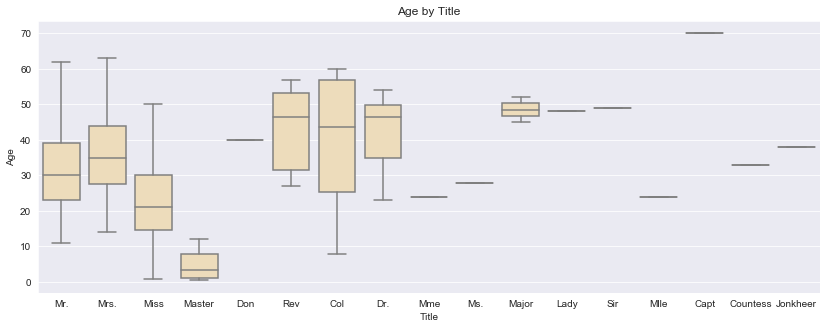

In [45]:
# Plot the passenger's title vs age
plt.figure(figsize=(14,5))
ax = sns.boxplot(y='Age', x='Title', data=df, showfliers = False, color='wheat');
ax.set_title('Age by Title');
ax.figure.savefig('Plots/age_by_title.png')

As expected, the older male passengers with titles such as Mr., Don., Rev., etc had a much lower survival rate than those with female titles (Mrs., Miss, etc).

Men with titles associated with religion had a 0.0% survival rate, while men with a military title had a greater chance of survival versus other adult males.

Women with a title of Miss were found to have a lower survival rate than those with Mrs., although that could be associated with the class of the passenger.

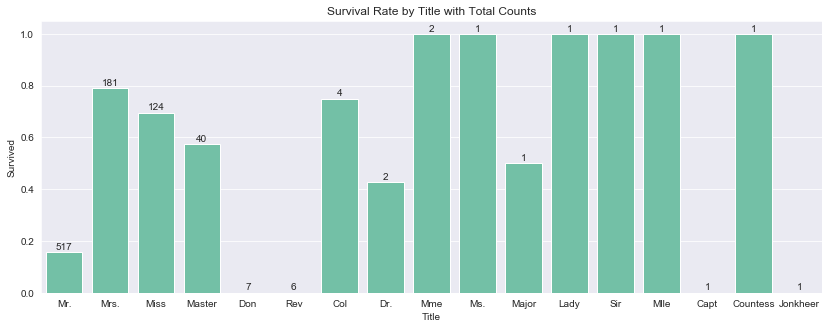

In [27]:
# Plot the passenger's title vs survival rate
plt.figure(figsize=(14,5))
ax = sns.barplot(x='Title', y='Survived', data=df, color='mediumaquamarine', ci=None);
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.01,
            df['Title'].value_counts()[i], ha="center") 
ax.set_title('Survival Rate by Title with Total Counts');

While most titles are gender-specific, both Dr. and Col. are not.

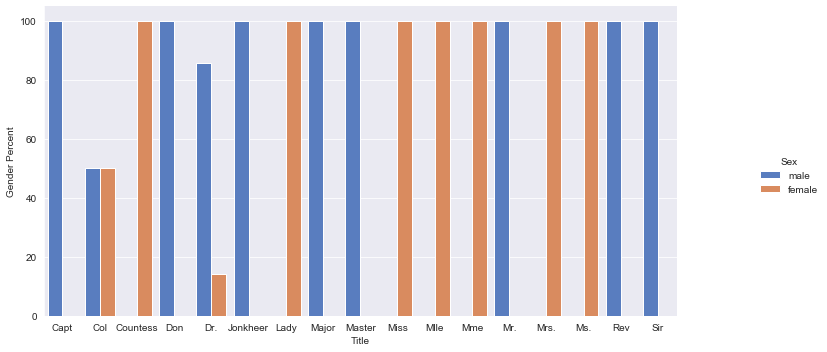

In [28]:
# Plot the passenger's title vs gender
x,y = 'Title', 'Sex'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Gender Percent').reset_index()

g = sns.catplot(x=x,y='Gender Percent',hue=y,kind='bar',data=df1)
g.fig.set_size_inches(12.5,5)

Those in the third class consisted only of passengers with the titles of "Master", "Miss", "Mr.", and "Mrs."

Those with the titles associated with either youth ("Master", or "Miss"), or non-professional men ("Mr.") were most likely to be found in third class.

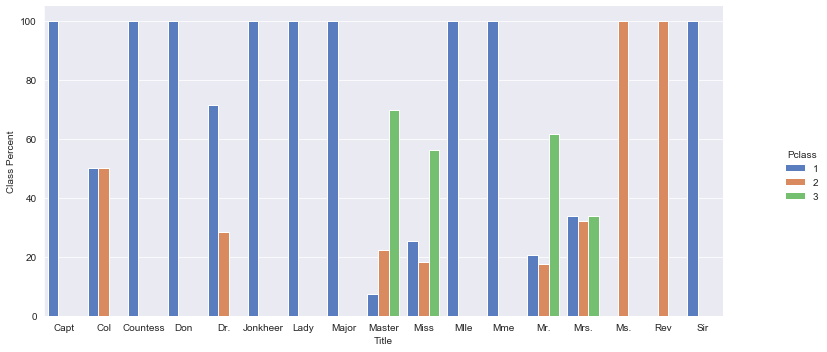

In [10]:
# Plot the passenger's title vs class
x,y = 'Title', 'Pclass'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Class Percent').reset_index()

g = sns.catplot(x=x,y='Class Percent',hue=y,kind='bar',data=df1)
g.fig.set_size_inches(12.5,5)

Non-professional men with the title of "Mr." were most likely to pay the least amount for the fare.

Ladies with the title "Miss" typically paid less than those with the title of "Mrs.", corresponding to the fact that those with "Miss" as a title were younger.

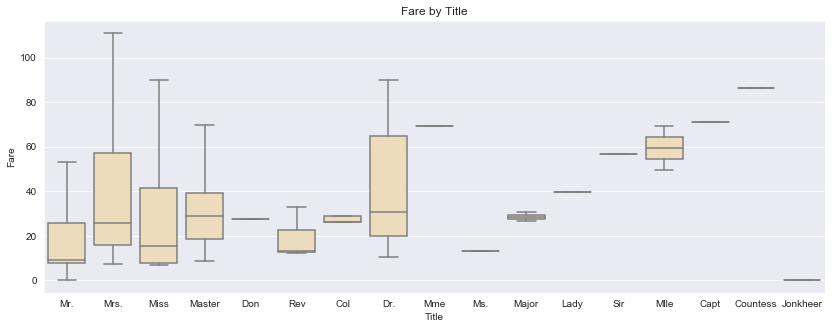

In [46]:
# Plot the passenger's title vs fare
plt.figure(figsize=(14,5))
ax = sns.boxplot(y='Fare', x='Title', data=df, showfliers = False, color='wheat');
ax.set_title('Fare by Title');

## 3.0 Feature Processing

This section will cover the necessary conversions and imputations necessary to prepapre the features for machine learning.

Since we will need to impute data, we will start fresh with a combined train and test dataset so that we can apply all changes to both.

In [2]:
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')
df_combined = train_df.append(test_df)

In [3]:
# Adding the columns we created during data exploration
df_combined['Sex_num'] = df_combined['Sex'].map({'female': 0, 'male': 1})
df_combined['Relatives'] = df_combined['SibSp'] + df_combined['Parch']
def extract_name(name):
    titles = ['Mr.', 'Don.', 'Dr.', 'Rev', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer', 'Mrs.', 'Ms.', 'Mme', 'Lady', 'Mlle', 'Countess', 'Dona.', 'Miss', 'Master']
    for title in titles:
        if title in name:
            return title
df_combined['Title'] = df_combined.apply(lambda row: extract_name(row['Name']), axis=1)
df_combined['Title'] = df_combined['Title'].replace('Mlle', 'Miss')
df_combined['Title'] = df_combined['Title'].replace('Ms.', 'Miss')
df_combined['Title'] = df_combined['Title'].replace('Mme', 'Mrs')
df_combined.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Relatives,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,Mr.
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,Mrs.
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,Mrs.
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,Mr.


In [4]:
# Check missing values
total = df_combined.isnull().sum().sort_values(ascending=False)
total.head(6)

Cabin       1014
Survived     418
Age          263
Embarked       2
Fare           1
Title          0
dtype: int64

### 3.1 Age

Although from data exploration age by itself does not seem to be a critical feature (other than for younger age groups), it may still be of importance in combination with other features and therefore we will perform imputation of missing ages.

Passenger class, sex and title were chosen as the best readily available features to represent age. The data was grouped by these features and the median value was found for each grouping. The median was chosen over the mean due to the relatively high standard deviation observed within ages.

We will also perform a min/max normalization on age, as it may be helpful for our distance-based algorithms, and could even improve numerical stability of regression models when calculating loss (source: https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0).`

In [5]:
# Impute age with the mean values of their respective Pclass, Sex and Title
grouped_median_age = df_combined.groupby(['Pclass', 'Sex','Title'])['Age'].median()
# Reset index to convert back to a regular dataframe
grouped_median_age = grouped_median_age.reset_index()
grouped_median_age.head(5)

,Pclass,Sex,Title,Age
0,1,female,Countess,33.0
1,1,female,Dona.,39.0
2,1,female,Dr.,49.0
3,1,female,Lady,48.0
4,1,female,Miss,30.0


In [6]:
# Function to impute age values:
def fill_age(row):
    condition = ((grouped_median_age['Pclass']==row['Pclass']) & (grouped_median_age['Sex']==row['Sex']) & (grouped_median_age['Title']==row['Title']))
    if len(grouped_median_age[condition]['Age'])==0:
        print('Match not found, generalizing condition')
        condition = ((grouped_median_age['Pclass']==row['Pclass']) & (grouped_median_age['Sex']==row['Sex']))
    return round(grouped_median_age[condition]['Age'].values[0], 1)

df_processed = df_combined.copy()
df_processed['Age'] = df_processed.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)


In [ ]:
# Bin the ages
def bin_age(age):
    binned_age = 0

    if age > 0 and age <= 15:
        binned_age = 0
    elif age > 15 and age <= 25:
        binned_age = 1
    elif age > 25 and age <= 35:
        binned_age = 2
    elif age > 35 and age <= 45:
        binned_age = 3
    elif age > 45 and age <= 55:
        binned_age = 4
    elif age > 55:
        binned_age = 5

    return binned_age

df_processed['Age_binned'] = df_processed.apply(lambda row: bin_age(row['Age']), axis=1)

In [7]:
df_processed[df_processed.Age.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Relatives,Title


### 3.2 Fare and Fare_per_person

We will create a fare-per-person column to better represent ticket fares. This will be accomplished by dividing fares by the number of times the ticket appears. Since the same ticket numbers may appear in both training and test set, we will combine the two.

In [8]:
# Impute missing fare value with median of that class
df_processed.Fare.fillna(df_processed[df_processed.Pclass==3]['Fare'].median(), inplace=True)

tickets = df_processed.groupby(['Ticket'])['PassengerId'].count().reset_index()

def fare_per_person(row):
    fare_per_person = row['Fare']/tickets[tickets.Ticket==row['Ticket']]['PassengerId']
    return fare_per_person.values[0]

df_processed['Fare_per_person'] = df_processed.apply(fare_per_person, axis=1)

df_processed.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Relatives,Title,Fare_per_person
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,Mr.,7.25000
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,Mrs.,35.64165
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,Miss,7.92500
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,Mrs.,26.55000
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,Mr.,8.05000


### 3.3 Embarked
Since there are only 2 missing values in the Embarked attribute, we can confidently fill them with the most common value (by far) of "S". Nominal non-binary categorical data (e.g. Embarked and Titles) will also require one hot encoding to prevent misinterpretation by the model as ordered data. We will use pandas built in functionality to accomplish this.

In [9]:
# Impute 2 missing values of embarked with most common value of 'S'
df_processed.Embarked.fillna(df_processed.Embarked.describe().top, inplace=True)

In [10]:
# Encode remaining non-numerical fields
# df['Embarked_num'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df_processed = pd.concat([df_processed, pd.get_dummies(df_processed['Embarked'], prefix='Embarked')], axis=1)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      1309 non-null   int64  
 1   Survived         891 non-null    float64
 2   Pclass           1309 non-null   int64  
 3   Name             1309 non-null   object 
 4   Sex              1309 non-null   object 
 5   Age              1309 non-null   float64
 6   SibSp            1309 non-null   int64  
 7   Parch            1309 non-null   int64  
 8   Ticket           1309 non-null   object 
 9   Fare             1309 non-null   float64
 10  Cabin            295 non-null    object 
 11  Embarked         1309 non-null   object 
 12  Sex_num          1309 non-null   int64  
 13  Relatives        1309 non-null   int64  
 14  Title            1309 non-null   object 
 15  Fare_per_person  1309 non-null   float64
 16  Embarked_C       1309 non-null   uint8  
 17  Embarked_Q     

## 3.4 Title

The most prominent titles observed during data exploration were Mr., Mrs., Miss and Master. Following preliminary machine learning models seemingly overfitting, it was determined to be beneficial to reduce the dimensionality of the model. A glaringly obvious choice would be to reduce the large number of titles into the most common ones and an "Other" category. 

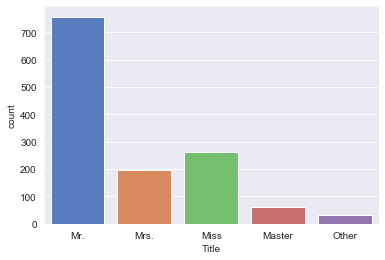

In [11]:
def group_titles(row):
    common_titles = ['Mr.', 'Mrs.', 'Miss', 'Master']
    if(row['Title'] not in common_titles):
        row['Title'] = 'Other'
    return row

df_processed = df_processed.apply(group_titles, axis=1)
ax = sns.countplot('Title', data=df_processed)

In [12]:
# Use titles because it includes titles in both training and test datasets
df_processed = pd.concat([df_processed, pd.get_dummies(df_processed['Title'], prefix='Title')], axis=1)
df_processed.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Fare_per_person,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr.,Title_Mrs.,Title_Other
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr.,7.25000,0,0,1,0,0,1,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Mrs.,35.64165,1,0,0,0,0,0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,7.92500,0,0,1,0,1,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Mrs.,26.55000,0,0,1,0,0,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr.,8.05000,0,0,1,0,0,1,0,0


### 3.5 Preparing Training and Test Set

Any attributes which would not be used as features were our model are dropped, and we separate data into a features and labels vector. Those vectors then undergo an 80/20 train/test split.

In [13]:
# Drop non-numerical and irrelevant rows
df_processed.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Fare'], axis=1, inplace=True)
df_processed.shape

(1309, 16)

In [14]:
# Set feature and label vectors for training set
X = df_processed[df_processed.Survived.isnull()==False].drop(['Survived'], axis=1)
y = df_processed[df_processed.Survived.isnull()==False]['Survived']

# Set feature vector for test set
X_test_set = df_processed[df_processed.Survived.isnull()].drop(['Survived'], axis=1)
print(f"Shape of the training set {X.shape}")
print(f"Shape of the test set {X_test_set.shape}")

Shape of the training set (891, 15)
Shape of the test set (418, 15)


In [15]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.0 Machine Learning

This section covers the training of various machine learning models in attempts of determining the best suited towards survival prediction.

### 4.1 Grid Search
Grid search was performed on multiple classifiers to find a model which balanced both training and testing scores.

In [16]:
y_sol = pd.read_csv('solutions.csv')
y_sol = y_sol['Survived']

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from time import time
np.random.seed(42)

classifiers = ['Logistic Regression', 'KNN', 'SVC', 'Decision Tree', 'Random Forest']


In [386]:
# 10 folds is recommended for an initial starting point for CV
rows_list = []
for classifier in classifiers:
    print(classifier)
    if classifier == 'Logistic Regression':
        clf = LogisticRegression()
        parameters = {'penalty':['l1', 'l2'], 'C': [0.001, 0.1, 1, 10, 100]}
    elif classifier == 'KNN':
        clf = KNeighborsClassifier()
        parameters = {'n_neighbors':[3, 5, 10], 'weights': ['uniform', 'distance']}
    elif classifier == 'SVC':
        # Note training time for linear was quite high so removed
        clf = SVC()
        parameters = {'kernel':['rbf'], 'C':[0.1, 1, 10, 100, 1000], 'gamma': ['auto']}
    elif classifier == "Decision Tree":
        clf = tree.DecisionTreeClassifier()
        parameters = {'min_samples_leaf':[1, 5, 10, 25], 'min_samples_split': [2, 4, 10, 12, 16, 18, 25, 35]}
    elif classifier == "Random Forest":
        clf = RandomForestClassifier()
        parameters = {'min_samples_leaf':[1, 5, 10, 25], 'min_samples_split': [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 200, 300]}
    # Train
    start_time = time()
    grid_search = GridSearchCV(clf, param_grid=parameters, cv=10)
    grid_search.fit(X_train, y_train)
    end_time = time()
    training_time = end_time-start_time
    # Test
    start_time = time()
    testing_score = grid_search.score(X_test, y_test)
    end_time = time()
    testing_time = end_time-start_time
    # Kaggle
    y_pred = grid_search.predict(X_test_set)
    kaggle_score = accuracy_score(y_pred, y_sol)
    d = {'Classifier': classifier, 'Training_score': round(grid_search.best_score_, 3), 'Testing_score': round(testing_score, 3), 'Kaggle_score': round(kaggle_score, 3), 'Training_time': round(training_time, 2), 'Testing_time': round(testing_time, 2)}
    d.update(grid_search.best_params_)
    rows_list.append(d)

Logistic Regression
C:\Users\arsal\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
KNN
SVC
C:\Users\arsal\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
Decision Tree
Random Forest
C:\Users\arsal\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 4.2 Voting Classifier

The top classifiers were combined in a voting classifier in hopes that individual weaknesses could be balanced out. Decision tree was not included due to redundancy with the random forest classifier.

In [388]:
clf1 = SVC(kernel='rbf', C=10.0, gamma='auto', probability=True)
clf2 = LogisticRegression(penalty='l1',C=1.0)
clf3 = RandomForestClassifier(min_samples_leaf=5, min_samples_split=16, n_estimators=300)
clf = VotingClassifier(estimators=[('SVC', clf1),('LR', clf2),('RF', clf3)], voting='soft')

start_time = time()
training_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
end_time = time()
training_time = end_time - start_time

clf.fit(X_train, y_train)

start_time = time()
testing_score = clf.score(X_test, y_test)
end_time = time()
testing_time = end_time - start_time

y_pred = grid_search.predict(X_test_set)
kaggle_score = accuracy_score(y_pred, y_sol)

d = {'Classifier': 'Voting Ensemble', 'Training_score': round(training_score, 3), 'Testing_score': round(testing_score, 3), 'Kaggle_score': round(kaggle_score, 3), 'Training_time': round(training_time, 2), 'Testing_time': round(testing_time, 2)}
rows_list.append(d)

### 4.3 Training Results

Random forest performed the best overall, with relatively high training and testing scores. As we had hoped, the combined efforts in the voting classifier also resulted in a good performance. Surprisingly, even though it was the simplest model, logistic regression was a near third.

In [391]:
results = pd.DataFrame(rows_list).sort_values(['Training_score', 'Kaggle_score', 'Testing_score'], ascending=False).reset_index(drop=True)
results.to_csv('final_model_scores.csv')
results.head(10)

,Classifier,Training_score,Testing_score,Kaggle_score,Training_time,Testing_time,C,penalty,n_neighbors,weights,gamma,kernel,min_samples_leaf,min_samples_split,n_estimators
0,Random Forest,0.841,0.827,0.770,307.96,0.04,NaN,NaN,NaN,NaN,NaN,NaN,5.0,16.0,300.0
1,Logistic Regression,0.831,0.832,0.761,3.45,0.00,10.0,l1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Voting Ensemble,0.829,0.832,0.770,4.25,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Decision Tree,0.819,0.860,0.761,3.24,0.00,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN
4,SVC,0.775,0.838,0.684,4.13,0.01,10.0,NaN,NaN,NaN,auto,rbf,NaN,NaN,NaN
5,KNN,0.747,0.838,0.632,1.47,0.01,NaN,NaN,5.0,distance,NaN,NaN,NaN,NaN,NaN


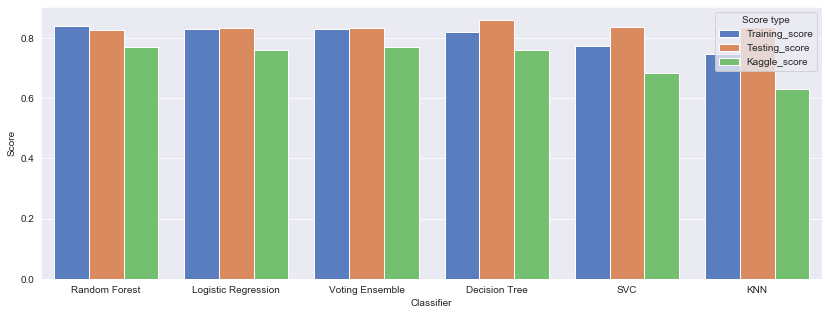

In [390]:
results_melt = results.melt(['Classifier'], var_name='Score type', value_vars=['Training_score', 'Testing_score', 'Kaggle_score'], value_name='Score')
fig, ax = plt.subplots(figsize=(14,5))
ax = sns.barplot(x='Classifier', y='Score', data=results_melt, hue='Score type')

### 4.4 Neural Network

Train a neural network with regularization mechanisms (such as Dropout) to avoid overfitting.

In [467]:
# ANN
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [478]:
# Convert the labels to one-hot encoding.
n_classes = 2
labels_train = np_utils.to_categorical(y, n_classes)
print(f'Shape of one hot encoded labels_train: {labels_train.shape}')

# Add a 32 node hidden layer with sigmoid activation function.
n_features = X.shape[1]

model = Sequential()
# model.add(Dropout(0.2))
model.add(Dense(256, input_dim=n_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, input_dim=n_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, input_dim=n_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, input_dim=n_features, activation='sigmoid'))

# Compile your model with accuracy as your metric.
opt=Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#Early stopping
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=60)

features_train = X.to_numpy()
# Train the model.
model_history = model.fit(features_train, labels_train, callbacks=[callbacks], epochs=200, batch_size=128, validation_split=0.10);

Shape of one hot encoded labels_train: (891, 2)
Train on 801 samples, validate on 90 samples
Epoch 1/200
801/801 [==============================] - 0s 317us/step - loss: 0.7016 - accuracy: 0.5718 - val_loss: 0.6444 - val_accuracy: 0.6444
Epoch 2/200
801/801 [==============================] - 0s 64us/step - loss: 0.6642 - accuracy: 0.6255 - val_loss: 0.6842 - val_accuracy: 0.6889
Epoch 3/200
801/801 [==============================] - 0s 51us/step - loss: 0.6874 - accuracy: 0.6754 - val_loss: 0.6883 - val_accuracy: 0.7222
Epoch 4/200
801/801 [==============================] - 0s 48us/step - loss: 0.6903 - accuracy: 0.6692 - val_loss: 0.6858 - val_accuracy: 0.7111
Epoch 5/200
801/801 [==============================] - 0s 50us/step - loss: 0.6901 - accuracy: 0.6592 - val_loss: 0.6795 - val_accuracy: 0.7444
Epoch 6/200
801/801 [==============================] - 0s 45us/step - loss: 0.6866 - accuracy: 0.6966 - val_loss: 0.6640 - val_accuracy: 0.7889
Epoch 7/200
801/801 [=====================

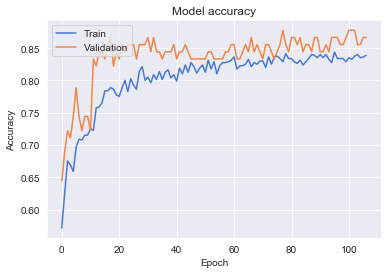

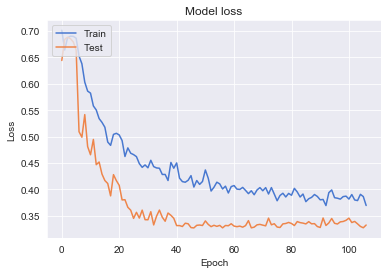

The score on the training set is 0.839
The score on the validation set is 0.867
Kaggle score: 0.7655502392344498


In [479]:
# Predict the test set labels.
y_pred = model.predict(X_test_set)
y_pred = np.argmax(y_pred, axis=-1)

# Plot training & validation accuracy values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# plt.savefig("Plots/neural_network_accuracy_sigmoid.png")
plt.show()
score = accuracy_score(y_pred, y_sol)


# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig("Plots/neural_network_loss_sigmoid.png")
plt.show()

print(f"The score on the training set is {model_history.history['accuracy'][-1]:.3f}")
print(f"The score on the validation set is {model_history.history['val_accuracy'][-1]:.3f}")
print("Kaggle score:", score)

In [18]:
ann_result = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_pred})
ann_result.to_csv('Submissions/ann_result_015_drop.csv', index=False)

NameError: name 'y_pred' is not defined

In [19]:
# Saving random forest classifier results to file
clf = RandomForestClassifier(min_samples_leaf=5, min_samples_split=16, n_estimators=300)
clf.fit(X, y)
y_pred = clf.predict(X_test_set)
rf_result = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_pred})
rf_result.to_csv('Submissions/rf_final_result.csv', index=False)